In [1]:
import cv2
import glob
from matplotlib import pyplot as plt
import numpy as np
from lessonFunctions import *
from sklearn.externals import joblib
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

print('Libraries Loaded!')

Libraries Loaded!


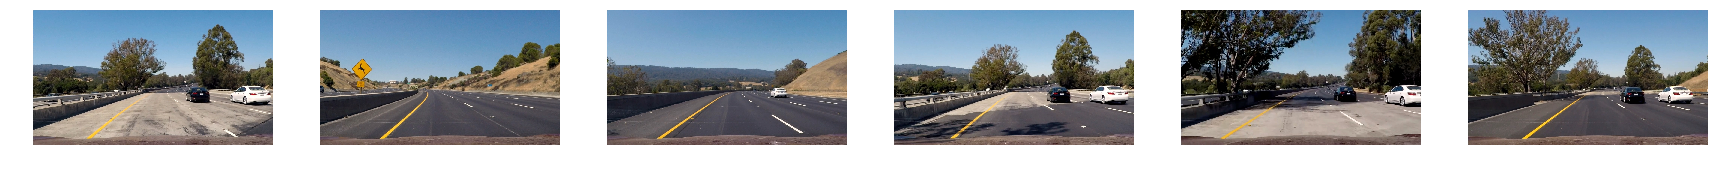

In [2]:
testImages = glob.glob('./test_images/*.jpg')
plt.figure(figsize=(30,10))
for i, img in enumerate(testImages):
    plt.subplot(1,len(testImages),i+1)
    img = plt.imread(img)
    plt.imshow(img)
    plt.axis('off')
plt.show()
testImage = plt.imread(testImages[0])

#### Slide Window Function

In [3]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [4]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(20, 255, 20), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

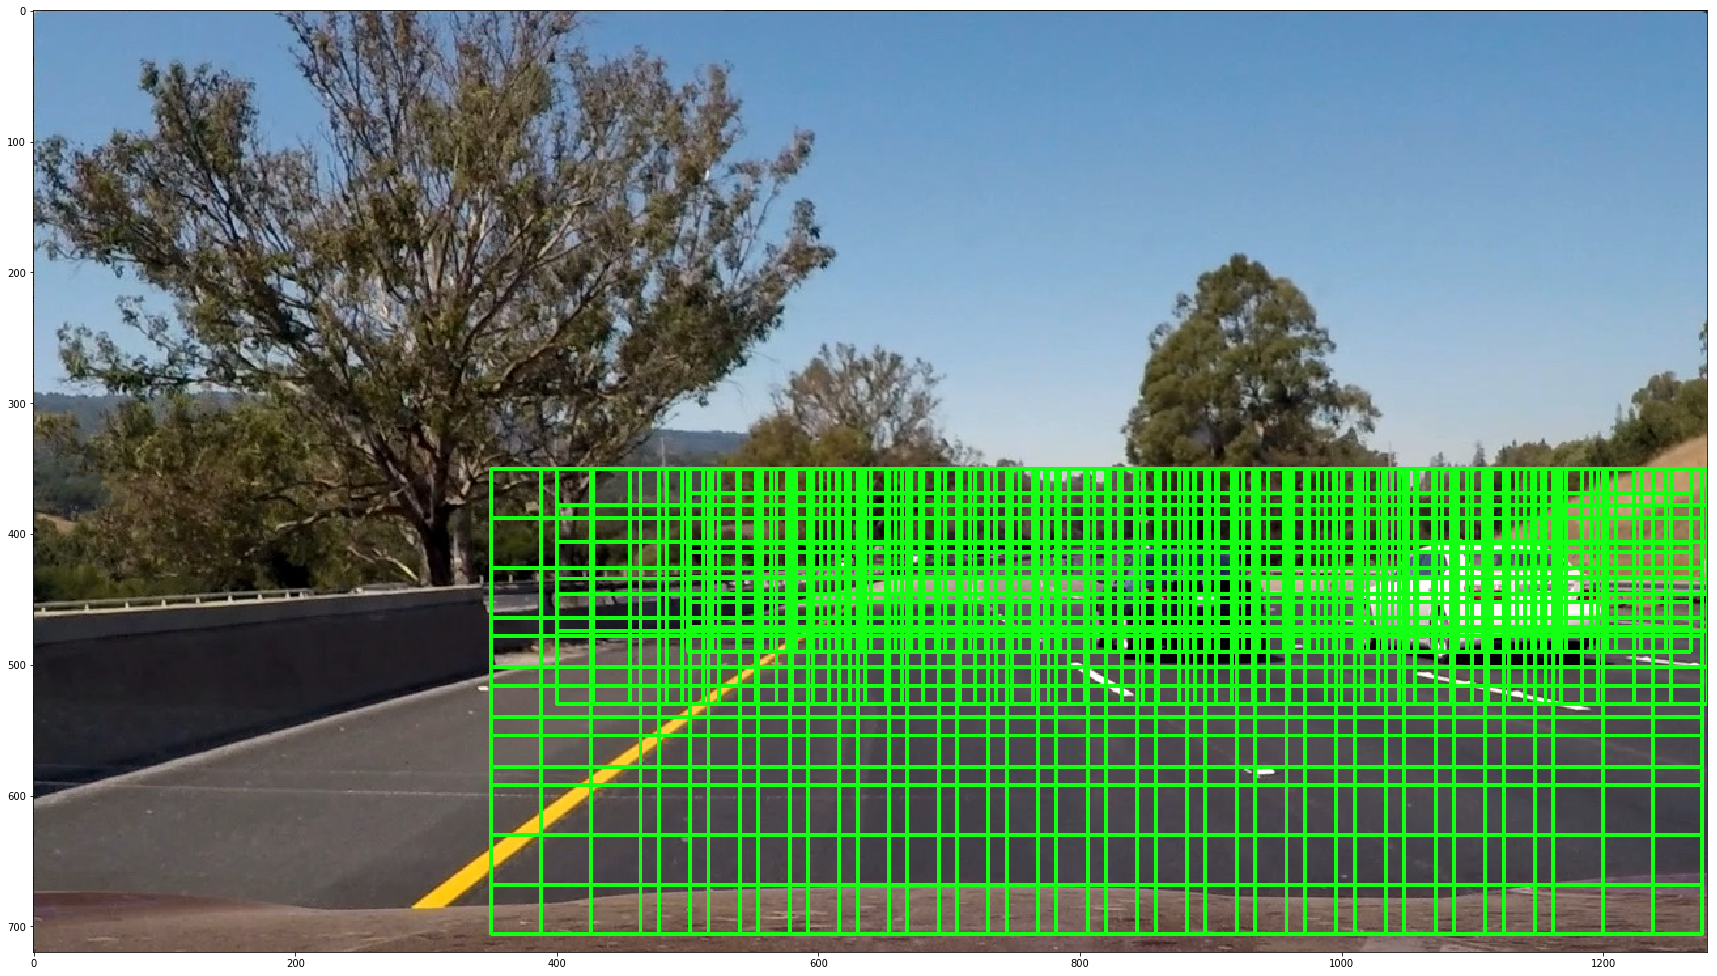

In [18]:
overlap = 0.7

boxes1 = slide_window(testImage, x_start_stop=[500,None],y_start_stop=[350,500], xy_window=(64,64), xy_overlap=(overlap,overlap))
boxes2 = slide_window(testImage, x_start_stop=[400,None],y_start_stop=[350,550], xy_window=(96,96), xy_overlap=(overlap,overlap))
boxes3 = slide_window(testImage, x_start_stop=[350,None],y_start_stop=[350,None], xy_window=(128,128), xy_overlap=(overlap,overlap))
boxes4 = slide_window(testImage, x_start_stop=[300,None],y_start_stop=[350,None], xy_window=(160,160), xy_overlap=(overlap,overlap))
# boxes4 = slide_window(testImage, x_start_stop=[40,1240],y_start_stop=[300,600], xy_window=(300,300), xy_overlap=(overlap,overlap))
# boxes5 = slide_window(testImage, x_start_stop=[10,1270],y_start_stop=[250,670], xy_window=(420,420), xy_overlap=(overlap,overlap))
windows = boxes1 + boxes2 + boxes3# + boxes4
pic = draw_boxes(testImage, windows, thick=2)
# pic = draw_boxes(testImage, boxes1, thick=2)
# pic = draw_boxes(pic, boxes2, thick=2)

plt.figure(figsize=(30,50))
plt.imshow(pic)
plt.show()

In [16]:
# Function to pull the features from a single image
def single_img_features(img, spatial_size=(32, 32), #, color_space='RGB'
                        hist_bins=32, hog_features=None,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
#     feature_image = convertCSpace(img, color_space)    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(img, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        _,_,_,_,hist_features = color_hist(img, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        #8) Append features to list
#         hog_features = compute_hog_features(img, orient=12, hog_channel='ALL')
        #print(hog_features.shape)
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [14]:
def compute_hog_features(img, orient=9,pix_per_cell=8, cell_per_block=2,
                         hog_channel=0, vis=False, feature_vec=True):
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(img.shape[2]):
            hog_features.append(get_hog_features(img[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=feature_vec))      
#         hog_features = np.ravel(hog_features)
    else:
        hog_features = get_hog_features(img[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=feature_vec)
    
    return np.array(hog_features)

In [8]:
def get_hog_window(window, test_img, hog_features, pix_per_cell=8):
    hog_offset = (window[0][0]//pix_per_cell, window[0][1]//pix_per_cell)
    hog_width = (test_img.shape[1]//pix_per_cell)-1
    return hog_features[:,hog_offset[1]:hog_offset[1]+hog_width, 
                        hog_offset[0]:hog_offset[0]+hog_width, :,:,:].ravel()

In [9]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
    #Change colour space of the image
    img = convertCSpace(img, color_space)
    # Generate Hog features for the whole image to speed it up
    if hog_feat:
        hogFeatures = compute_hog_features(img, orient, pix_per_cell,
                                            cell_per_block, hog_channel,
                                            feature_vec=False)
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        if hog_feat:
            hog_window = get_hog_window(window, test_img, hogFeatures, pix_per_cell)
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, #color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            hog_features=hog_window, spatial_feat=spatial_feat, #
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [ ]:
# Get hog and small part of hog
testImage = plt.imread(testImages[0])
hogFeatures = get_hog_features(testImage[:,:,0], 
                                    orient=12, pix_per_cell=8, cell_per_block=2, 
                                    vis=False, feature_vec=False)

pix_per_cell = 8
# Pull 64x64 image from image
imgPos = (400, 464, 800,864)
smallImage = testImage[imgPos[0]:imgPos[1], imgPos[2]:imgPos[3]]
plt.imshow(testImage)
plt.show()
plt.imshow(smallImage)
plt.show()
print(hogFeatures.shape)
# Get hog for small image compare to pulled hog features
hogFeatures_small = get_hog_features(smallImage[:,:,0], 
                                    orient=12, pix_per_cell=8, cell_per_block=2, 
                                    vis=False, feature_vec=True)
hogPos = (imgPos[0]//pix_per_cell, imgPos[2]//pix_per_cell)
hogWidth = (64//pix_per_cell)-1
hogFeatures_pulled = hogFeatures[hogPos[0]:hogPos[0]+hogWidth, hogPos[1]:hogPos[1]+hogWidth,:,:,:]
hogFeatures_pulled = hogFeatures_pulled.ravel()
print(hogFeatures_small.shape)
print(hogFeatures_pulled.shape)
plt.plot(hogFeatures_small)
plt.show()
plt.plot(hogFeatures_pulled)
plt.show()
plt.plot(hogFeatures_small-hogFeatures_pulled)
plt.show()

In [10]:
filename = './model/bestFit_0.9932.pkl'
svc = joblib.load(filename)
filename = './model/scaler_0.9932.pkl'
scaler = joblib.load(filename)

In [ ]:
testImg = plt.imread(testImages[2])
plt.imshow(testImg)
plt.show()
for i, window in enumerate(windows):
    img = cv2.resize(testImg[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
    filename = './problemImages/image_{}.png'.format(i)
    plt.imsave(filename, img)

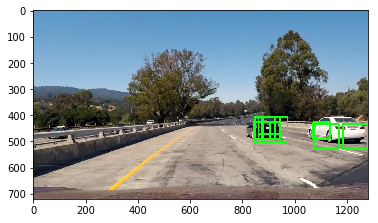

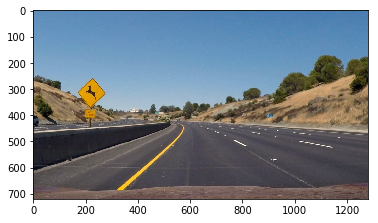

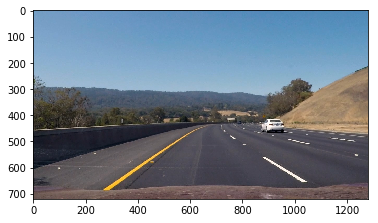

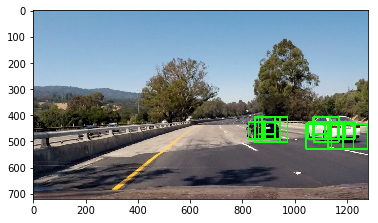

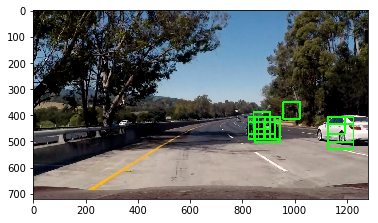

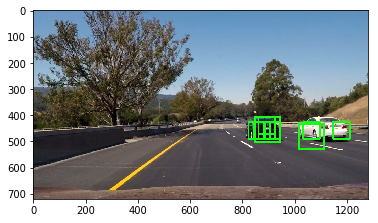

In [19]:
# cspace = 'LAB' #'HSV','LUV',HLS','YUV','YCrCb', 'RGB'
# spatial_size = (32,32)
# hist_bins = 32
# hist_range = (0,256)
# orient = 12
# pixPerCell = 8
# cellPerBlock = 2
# hogChannel = 'All'


# MORE WINDOWS
# OVERFITTING CLASSIFIER
for img in testImages:
    testImage = plt.imread(img)
    hot_windows = search_windows(testImage, windows, svc, scaler, 
                    color_space='LAB', orient=12, pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True)
    windowImg = draw_boxes(testImage, hot_windows)
    plt.imshow(windowImg)
    plt.show()

In [21]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add 1 for all pixles inside of the box
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

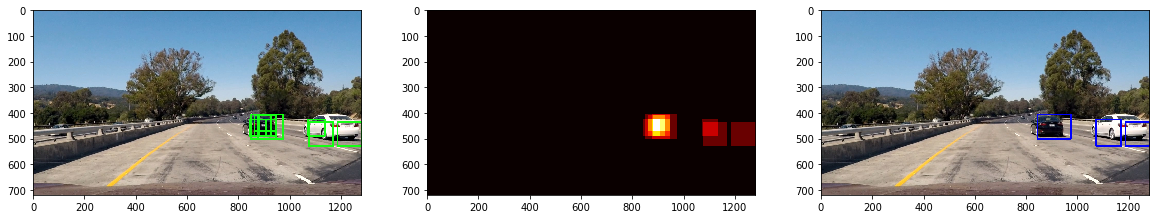

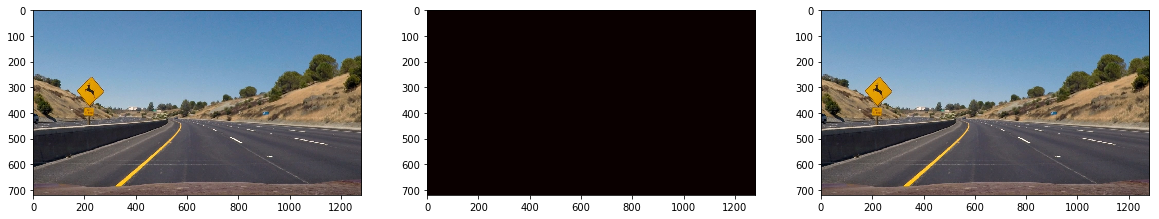

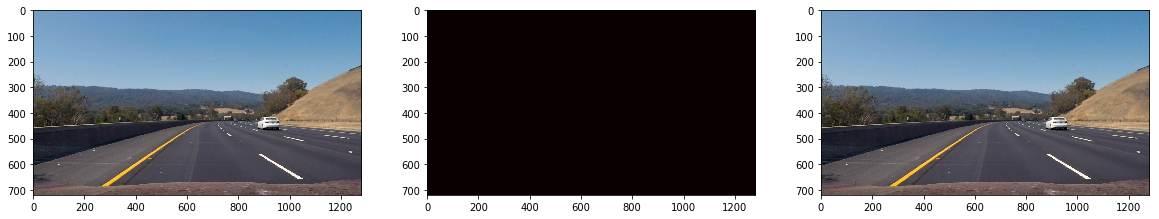

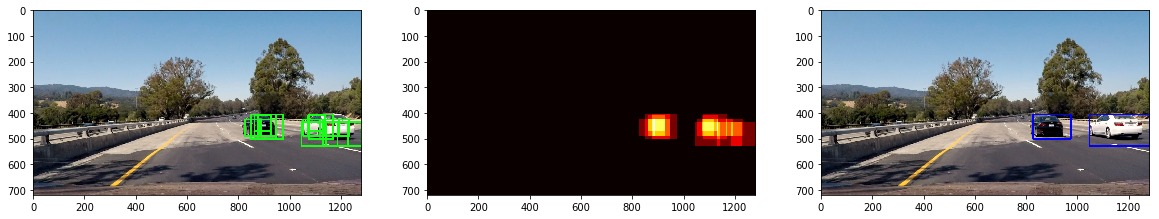

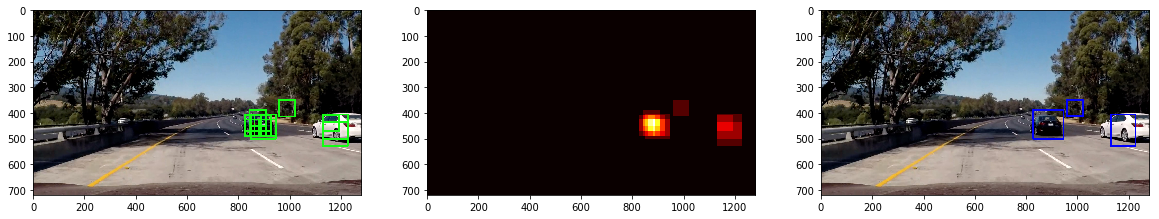

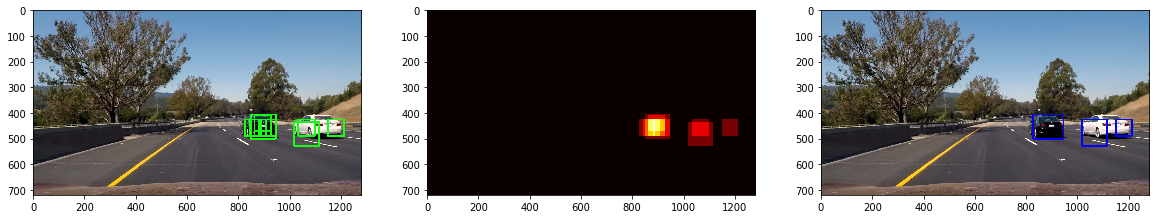

In [22]:
for file in testImages:
    plt.figure(figsize=(20,30))
    image = plt.imread(file)
    hot_windows = search_windows(image, windows, svc, scaler, 
                    color_space='LAB', orient=12, pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True)
    windowImg = draw_boxes(image, hot_windows)
    plt.subplot(131)
    plt.imshow(windowImg)
    
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap, 0)
    heatmap = np.clip(heatmap, 0, 255)
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    labels = label(heatmap)
    
    drawImg = draw_labeled_bboxes(np.copy(image), labels)
    plt.subplot(133)
    plt.imshow(drawImg)
    plt.show()
    

In [23]:
def findCars(image):
    hot_windows = search_windows(image, windows, svc, scaler, 
                    color_space='YUV', orient=12, pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True)
    
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap, 0)
    heatmap = np.clip(heatmap, 0, 255)
    
    labels = label(heatmap)
    
    drawImg = draw_labeled_bboxes(np.copy(image), labels)
    
    return drawImg

In [24]:
fileOutput = 'test.mp4'
clip1 = VideoFileClip('project_video_short.mp4')
processedVideo = clip1.fl_image(findCars)
%time processedVideo.write_videofile(fileOutput, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|████████████████████████████████████████████████████████████| 414/414 [06:53<00:00,  1.00s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

Wall time: 6min 54s
